In [30]:
import pandas as pd
import numpy as np
import json
import seaborn as sns

import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from tools import *

# Defining MLP Architecture

In [31]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers):
        super(MLP, self).__init__()
        
        # Create a list to hold the layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())  # Add activation after first hidden layer
        
        # Add hidden layers
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.ReLU())  # Add activation after hidden layers
        
        # Add the output layer
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
        
        # Use nn.Sequential to combine layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [32]:

# Load your data
merged_dataset = pd.read_csv('datasets/merged_dataset.csv', low_memory=False)  # Assuming your data is in a CSV file
filtered_dataset = pd.read_csv('datasets/filtered_dataset.csv', low_memory=False)  # Assuming your data is in a CSV file

In [ ]:
nb_ATAC_seq_rows = 8
ATAC_seq_names = merged_dataset.columns[:nb_ATAC_seq_rows]
all_names = ""
for name in ATAC_seq_names:
    all_names += f' {name}'
print(all_names)

In [ ]:
# Regions of interest

reg_interest = ['promoter', 'enhancer', 'geneBody']
reg_ix_interest = []
min_common_occ_nb = 1000000
for region in reg_interest:
    occ_reg = (filtered_dataset['region']==region_dict[region]).sum()
    if occ_reg < min_common_occ_nb:
        min_common_occ_nb = occ_reg
    print((filtered_dataset['region']==region_dict[region]).sum())



# Grid Search for 2 Hidden Layers

In [42]:

nb_datasets = 1
nb_runs = 4
nb_hidden_layers = 2
list_nb_hn_1 = [4]
list_nb_hn_2 = [16]


l_rate = 10 # *0.001

compendium_rows = nb_datasets*nb_runs*len(list_nb_hn_1)*len(list_nb_hn_2)
compendium = array_zeros = np.zeros((compendium_rows, 2+nb_hidden_layers+1)) # 2 as in: dataset, run | 1 as in: performance

compendium_idx = 0
best_mean_precisions = 0
best_loss = 10
for dataset_ix in range(nb_datasets):


    # Define the number of samples for each region
    N = int(min_common_occ_nb*0.8)  # Adjust this value as needed

    # Select N random rows for each region
    sample_list = []
    for roi in reg_interest:
        sample_list.append(filtered_dataset[filtered_dataset['region'] == region_dict[roi]].sample(n=N, random_state=42))

    # Concatenate the sampled rows to create the final dataset
    balanced_dataset = pd.concat(sample_list, ignore_index=True)

    X = balanced_dataset.drop(['peakStart', 'peakEnd', 'peakName', 'peakScore', 'FGRstart', 'FGRend', 'FGRstrand', 'region'], axis=1).values  # Features
    y = balanced_dataset['region'].values  # Target variable


    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    input_size = X_train.shape[1]

    for run_idx in range(nb_runs):
        for nb_hn_1 in list_nb_hn_1:
            for nb_hn_2 in list_nb_hn_2:
                list_nb_hn = [nb_hn_1, nb_hn_2]


                # Instantiate the model
                model = MLP(input_size, len(reg_interest), list_nb_hn)  # Use the dynamic MLP model

                # Define the loss function and optimizer
                criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
                optimizer = optim.Adam(model.parameters(), lr=l_rate*0.001)  # Adam optimizer

                # Train the model
                num_epochs = 500
                
                loss_vs_epoch = []
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()  # Clear the gradients
                    outputs = model(X_train_tensor)  # Forward pass
                    loss = criterion(outputs, y_train_tensor)  # Compute loss
                    loss.backward()  # Backward pass
                    optimizer.step()  # Update weights

                    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
                        print(f'Run {compendium_idx+1}/{compendium.shape[0]} : Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
                    loss_vs_epoch.append(loss.item())


                # Evaluate the model
                model.eval()
                with torch.no_grad():
                    y_pred = model(X_test_tensor)  # Forward pass
                    _, predicted_classes = torch.max(y_pred, 1)  # Get predicted class labels

                # Print evaluation metrics
                report_dict = classification_report(y_test, predicted_classes.numpy(), target_names=reg_interest, output_dict=True, zero_division=0)

                # Store the precision values in a variable
                precisions = {key: value['precision'] for key, value in report_dict.items() if key != 'accuracy'}
                recalls = {key: value['recall'] for key, value in report_dict.items() if key != 'accuracy'}
                f1_scores = {key: value['f1-score'] for key, value in report_dict.items() if key != 'accuracy'}
                supports = {key: value['support'] for key, value in report_dict.items() if key != 'accuracy'}

                mean_precisions = np.mean([precisions['promoter'],precisions['geneBody']])


                # if mean_precisions > best_mean_precisions:
                if loss.item() < best_loss:
                    best_y_test = y_test
                    best_predicted_classes = predicted_classes
                    best_loss_vs_epoch = loss_vs_epoch
                    best_mean_precisions = mean_precisions
                    best_loss = loss.item()


                compendium[compendium_idx] = [dataset_ix, run_idx, nb_hn_1, nb_hn_2, mean_precisions] 
                compendium_idx += 1


print(f'{compendium[np.argmax(compendium[:, -1])]}')


Run 1/4 : Epoch [10/500], Loss: 0.9181
Run 1/4 : Epoch [20/500], Loss: 0.8419
Run 1/4 : Epoch [30/500], Loss: 0.8113
Run 1/4 : Epoch [40/500], Loss: 0.7938
Run 1/4 : Epoch [50/500], Loss: 0.7834
Run 1/4 : Epoch [60/500], Loss: 0.7765
Run 1/4 : Epoch [70/500], Loss: 0.7707
Run 1/4 : Epoch [80/500], Loss: 0.7658
Run 1/4 : Epoch [90/500], Loss: 0.7618
Run 1/4 : Epoch [100/500], Loss: 0.7586
Run 1/4 : Epoch [110/500], Loss: 0.7564
Run 1/4 : Epoch [120/500], Loss: 0.7537
Run 1/4 : Epoch [130/500], Loss: 0.7518
Run 1/4 : Epoch [140/500], Loss: 0.7503
Run 1/4 : Epoch [150/500], Loss: 0.7491
Run 1/4 : Epoch [160/500], Loss: 0.7477
Run 1/4 : Epoch [170/500], Loss: 0.7469
Run 1/4 : Epoch [180/500], Loss: 0.7457
Run 1/4 : Epoch [190/500], Loss: 0.7448
Run 1/4 : Epoch [200/500], Loss: 0.7438
Run 1/4 : Epoch [210/500], Loss: 0.7440
Run 1/4 : Epoch [220/500], Loss: 0.7429
Run 1/4 : Epoch [230/500], Loss: 0.7422
Run 1/4 : Epoch [240/500], Loss: 0.7411
Run 1/4 : Epoch [250/500], Loss: 0.7402
Run 1/4 :

              precision    recall  f1-score   support

    promoter       0.77      0.71      0.74      2330
    enhancer       0.58      0.54      0.56      2435
    geneBody       0.62      0.71      0.66      2360

    accuracy                           0.65      7125
   macro avg       0.66      0.65      0.65      7125
weighted avg       0.66      0.65      0.65      7125



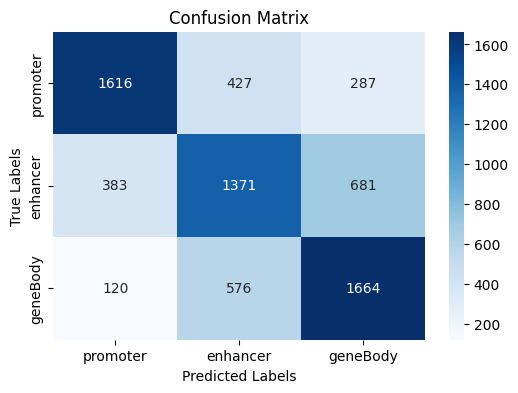

Best Combination:
nb_hn_l0: 4
nb_hn_l1: 16
Mean(Acc): 0.697
Stdev(Acc): 0.005


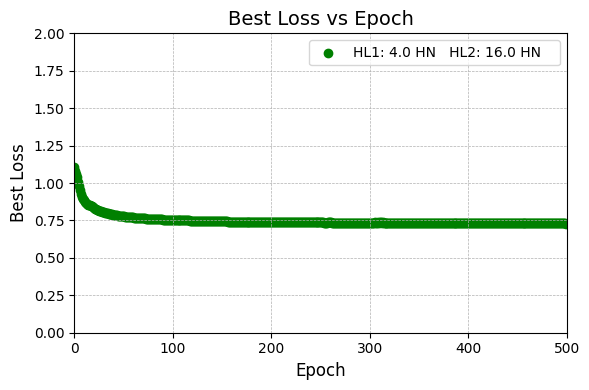

In [43]:

print(classification_report(y_test, predicted_classes.numpy(), target_names=reg_interest, zero_division=0))
plot_results(nb_hidden_layers, reg_interest, best_y_test, best_predicted_classes, best_loss_vs_epoch, compendium, l_rate)